### Set Up

In [1]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


In [2]:
rides = pd.read_parquet("output/rides/part-00003-0b2edece-76c6-47ea-b857-9b1337697005-c000.snappy.parquet")
rides.to_csv("rides.csv", index=False)
print(rides.columns)
rides.head()

FileNotFoundError: [Errno 2] No such file or directory: 'output/rides/part-00003-0b2edece-76c6-47ea-b857-9b1337697005-c000.snappy.parquet'

In [20]:
special = pd.read_parquet("output/specials/part-00000-9734db12-dfe5-47bc-913e-45f718cdb6da-c000.snappy.parquet")
special.to_csv("special.csv", index=False)
print(special.columns)
special.head()

Index(['event_type', 'event_name', 'venue_zone', 'venue_latitude',
       'venue_longitude', 'venue_address', 'venue_city', 'event_start',
       'event_end', 'arrivals_start', 'arrivals_end', 'departures_start',
       'departures_end', 'arrival_rides', 'departure_rides',
       'estimated_attendees'],
      dtype='object')


,event_type,event_name,venue_zone,venue_latitude,venue_longitude,venue_address,venue_city,event_start,event_end,arrivals_start,arrivals_end,departures_start,departures_end,arrival_rides,departure_rides,estimated_attendees
0,sports,Atlético de Madrid vs Sevilla FC Game,malasana,40.426498,-3.7025,301 Sports Stadium,Madrid,2025-01-01 16:00:00,2025-01-01 19:00:00,2025-01-01 14:00:00,2025-01-01 16:15:00,2025-01-01 18:45:00,2025-01-01 20:30:00,3113,4003,37080
1,sports,Atlético de Madrid vs Sevilla FC Game,malasana,40.426498,-3.7025,301 Sports Stadium,Madrid,2025-01-01 16:00:00,2025-01-01 19:00:00,2025-01-01 14:00:00,2025-01-01 16:15:00,2025-01-01 18:45:00,2025-01-01 20:30:00,3113,4003,37080
2,concert,Concert Event 2,airport,40.498299,-3.5676,598 Airport Calle,Madrid,2025-01-01 19:00:00,2025-01-01 22:00:00,2025-01-01 16:00:00,2025-01-01 19:15:00,2025-01-01 21:30:00,2025-01-02 00:00:00,2090,2351,8004
3,sports,Atlético de Madrid vs Sevilla FC Game,malasana,40.426498,-3.7025,301 Sports Stadium,Madrid,2025-01-01 16:00:00,2025-01-01 19:00:00,2025-01-01 14:00:00,2025-01-01 16:15:00,2025-01-01 18:45:00,2025-01-01 20:30:00,3113,4003,37080
4,concert,Concert Event 2,airport,40.498299,-3.5676,598 Airport Calle,Madrid,2025-01-01 19:00:00,2025-01-01 22:00:00,2025-01-01 16:00:00,2025-01-01 19:15:00,2025-01-01 21:30:00,2025-01-02 00:00:00,2090,2351,8004


In [21]:
# Function to map levels to indices
def map_level(level, dictionary):
    if level in dictionary:
        return dictionary[level]
    else:
        # Return the next index after known categories as the "other" category
        return len(dictionary)

### Creating User Profiles

#### Determining if Special Events' Rides

In [23]:
latitude_adjustment = 0.00449 # Equivalent to 0.5km
longitude_adjustment = 0.0059 # Equivalent to 0.5km
loc_spec_lat = special.iloc[0]["venue_latitude"]
loc_spec_lon = special.iloc[0]["venue_longitude"]

lat_interval = [loc_spec_lat - latitude_adjustment, loc_spec_lat + latitude_adjustment]
lon_interval = [loc_spec_lon - longitude_adjustment, loc_spec_lon + longitude_adjustment]


for row in rides.iterrows():
    if row[1]["pickup_latitude"] >= lat_interval[0] and row[1]["pickup_latitude"] <= lat_interval[1] and row[1]["pickup_longitude"] >= lon_interval[0] and row[1]["pickup_longitude"] <= lon_interval[1]:
        print("Leaving -> ride id: ", row[0])
    elif row[1]["dropoff_latitude"] >= lat_interval[0] and row[1]["dropoff_latitude"] <= lat_interval[1] and row[1]["dropoff_longitude"] >= lon_interval[0] and row[1]["dropoff_longitude"] <= lon_interval[1]:
        print("Coming -> ride id: ", row[0])



Leaving -> ride id:  29
Leaving -> ride id:  30
Leaving -> ride id:  31
Leaving -> ride id:  35
Leaving -> ride id:  90
Coming -> ride id:  100
Coming -> ride id:  101
Leaving -> ride id:  102
Leaving -> ride id:  103
Leaving -> ride id:  104
Coming -> ride id:  122
Coming -> ride id:  123
Coming -> ride id:  124
Leaving -> ride id:  150
Leaving -> ride id:  151
Leaving -> ride id:  152
Leaving -> ride id:  153
Leaving -> ride id:  174
Leaving -> ride id:  179
Leaving -> ride id:  180
Leaving -> ride id:  181
Coming -> ride id:  211
Coming -> ride id:  212
Coming -> ride id:  219
Coming -> ride id:  220
Coming -> ride id:  221
Coming -> ride id:  250
Coming -> ride id:  251
Coming -> ride id:  252
Leaving -> ride id:  268
Leaving -> ride id:  269
Leaving -> ride id:  270
Coming -> ride id:  298
Leaving -> ride id:  307


In [24]:
# Function to check if a point is within the defined area
def is_within_area(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return False
    return (lat_interval[0] <= lat <= lat_interval[1] and 
            lon_interval[0] <= lon <= lon_interval[1])

def determine_ride_direction(row, venue_lat, venue_lon, distance_km=0.5):
    """
    Determines if a ride is coming to, leaving from, or unrelated to a venue.
    
    Parameters:
    - row: A row from the rides dataframe
    - venue_lat: Latitude of the venue
    - venue_lon: Longitude of the venue
    - distance_km: Distance threshold in kilometers
    
    Returns:
    - 'coming', 'leaving', or None
    """
    # Constants for latitude/longitude adjustments
    latitude_adjustment = 0.009898 * distance_km
    longitude_adjustment = 0.00118 * distance_km
    
    # Define intervals around the venue
    lat_interval = [venue_lat - latitude_adjustment, venue_lat + latitude_adjustment]
    lon_interval = [venue_lon - longitude_adjustment, venue_lon + longitude_adjustment]
    
    # Check if pickup/dropoff locations are within the area
    def is_within_area(lat, lon):
        if pd.isna(lat) or pd.isna(lon):
            return False
        return (lat_interval[0] <= lat <= lat_interval[1] and 
                lon_interval[0] <= lon <= lon_interval[1])
    
    pickup_in_area = is_within_area(row["pickup_latitude"], row["pickup_longitude"])
    dropoff_in_area = is_within_area(row["dropoff_latitude"], row["dropoff_longitude"])
    
    if pickup_in_area and not dropoff_in_area:
        return 'leaving'
    elif not pickup_in_area and dropoff_in_area:
        return 'coming'
    else:
        return None


In [25]:
a = determine_ride_direction(rides.iloc[72], loc_spec_lat, loc_spec_lon)
print(a)

None


In [26]:
def analyze_rides_for_all_events(rides_df, special_df, distance_km=0.5):
    """
    Creates two new columns in the rides dataframe:
    1. 'event_direction': indicates if a ride was coming to, leaving from, or unrelated to any event
    2. 'event_name': indicates which event the ride was related to, if any
    
    Parameters:
    - rides_df: DataFrame containing ride data
    - special_df: DataFrame containing special event data
    - distance_km: Distance threshold in kilometers
    
    Returns:
    - rides_df with two new columns
    """
    # Create a dictionary of unique events with their coordinates
    # Use event_name as key and (lat, lon) as value
    events_dict = {}
    
    # Drop duplicates to get unique events (based on name, latitude, and longitude)
    unique_events = special_df.drop_duplicates(subset=['event_name', 'venue_latitude', 'venue_longitude', 'event_type'])
    
    for _, event in unique_events.iterrows():
        event_type = event['event_type']
        lat = event['venue_latitude']
        lon = event['venue_longitude']
        events_dict[event_type] = (lat, lon)
    
    # Initialize new columns
    rides_df['event_direction'] = None
    rides_df['event_name'] = None
    
    # Process each ride
    for idx, ride in rides_df.iterrows():
        # Check each event for this ride
        for event_name, (lat, lon) in events_dict.items():
            direction = determine_ride_direction(ride, lat, lon, distance_km)
            
            # If we found a relationship with this event, update the columns and break
            if direction is not None:
                rides_df.at[idx, 'event_direction'] = direction
                rides_df.at[idx, 'event_name'] = event_name
                break
    
    return rides_df

In [27]:
rides_with_event_info = analyze_rides_for_all_events(rides, special)

#### Creating User Vectors

In [28]:
# Subset of the data to be used for user profile creation
rides_subset = rides_with_event_info[["timestamp","user_id","pickup_latitude",
                       "pickup_longitude","dropoff_latitude","dropoff_longitude",
                       "event_direction","event_name",
                       "distance_km"]]
rides_subset["month"] = rides_subset["timestamp"].dt.month
rides_subset["day"] = rides_subset["timestamp"].dt.day
rides_subset["hour"] = rides_subset["timestamp"].dt.hour
rides_subset["day_of_week"] = rides_subset["timestamp"].dt.dayofweek
rides_subset["day_of_year"] = rides_subset["timestamp"].dt.dayofyear

rides_subset.drop(columns=["timestamp"], inplace=True)
rides_subset.head()

C:\Users\fabia\AppData\Local\Temp\ipykernel_49932\3854892021.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_subset["month"] = rides_subset["timestamp"].dt.month
C:\Users\fabia\AppData\Local\Temp\ipykernel_49932\3854892021.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_subset["day"] = rides_subset["timestamp"].dt.day
C:\Users\fabia\AppData\Local\Temp\ipykernel_49932\3854892021.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

,user_id,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,event_direction,event_name,distance_km,month,day,hour,day_of_week,day_of_year
0,U000282,40.425538,-3.682391,40.416818,-3.704002,None,None,2.070527,1,1,7,2,1
1,U000079,40.416894,-3.703969,40.425633,-3.682257,None,None,2.079023,1,1,7,2,1
2,U000079,40.416894,-3.703969,40.425633,-3.682257,None,None,2.079023,1,1,7,2,1
3,U000003,40.408542,-3.702342,40.408497,-3.702551,None,None,0.018402,1,1,8,2,1
4,U000003,40.408542,-3.702342,40.408497,-3.702551,None,None,0.018402,1,1,8,2,1


In [29]:
# Create user profile features
user_features = pd.DataFrame()

# Group by user_id to create aggregated features
user_groups = rides_subset.groupby('user_id')

# Basic stats features
user_features['user_id'] = user_groups['user_id'].first()
user_features['total_rides'] = user_groups.size()
user_features['avg_distance_km'] = user_groups['distance_km'].mean()
user_features['max_distance_km'] = user_groups['distance_km'].max()


In [30]:
# Location features - average pickup and dropoff coordinates
user_features['avg_pickup_latitude'] = user_groups['pickup_latitude'].mean()
user_features['avg_pickup_longitude'] = user_groups['pickup_longitude'].mean()
user_features['avg_dropoff_latitude'] = user_groups['dropoff_latitude'].mean()
user_features['avg_dropoff_longitude'] = user_groups['dropoff_longitude'].mean()

In [31]:
# Time-based features
user_features['most_common_hour'] = user_groups['hour'].agg(lambda x: x.value_counts().index[0])
user_features['most_common_day_of_week'] = user_groups['day_of_week'].agg(lambda x: x.value_counts().index[0])
user_features['weekend_ride_ratio'] = user_groups['day_of_week'].apply(
    lambda x: sum(x.isin([5, 6])) / len(x) if len(x) > 0 else 0
)

In [32]:
# Event-related features - corrected with your naming convention
user_features['to_event_ratio'] = user_groups['event_direction'].apply(
    lambda x: sum(x == 'comming') / len(x) if len(x) > 0 else 0
)
user_features['from_event_ratio'] = user_groups['event_direction'].apply(
    lambda x: sum(x == 'leaving') / len(x) if len(x) > 0 else 0
)

# Get most common event attended per user - fixed to handle empty value_counts
user_features['most_common_event'] = user_groups['event_name'].agg(
    lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 else 'no_event'
)

In [33]:
# Calculate variance in ride patterns
user_features['distance_variance'] = user_groups['distance_km'].var()
user_features['hour_variance'] = user_groups['hour'].var()

# Reset index for the final dataframe
user_features = user_features.reset_index(drop=True)

# Display the features
print(user_features.shape)
print(user_features.columns)

(100, 16)
Index(['user_id', 'total_rides', 'avg_distance_km', 'max_distance_km',
       'avg_pickup_latitude', 'avg_pickup_longitude', 'avg_dropoff_latitude',
       'avg_dropoff_longitude', 'most_common_hour', 'most_common_day_of_week',
       'weekend_ride_ratio', 'to_event_ratio', 'from_event_ratio',
       'most_common_event', 'distance_variance', 'hour_variance'],
      dtype='object')


In [34]:
# Get unique traffic levels
unique_events = user_features["most_common_event"].unique()

# Create a mapping dictionary with an index for each unique traffic level
events = {}
for i, level in enumerate(unique_events):
    events[level] = i
print(events)

# Apply the mapping function
user_features["most_common_event"] = user_features["most_common_event"].apply(map_level, args=(events,))

# Alternatively, you can use the map function with a default value
# rides_outlier_subset["traffic_level"] = rides_outlier_subset["traffic_level"].map(
#     traffic_levels).fillna(len(traffic_levels)).astype(int)

user_features.head()

{'no_event': 0, 'concert': 1, 'sports': 2}


,user_id,total_rides,avg_distance_km,max_distance_km,avg_pickup_latitude,avg_pickup_longitude,avg_dropoff_latitude,avg_dropoff_longitude,most_common_hour,most_common_day_of_week,weekend_ride_ratio,to_event_ratio,from_event_ratio,most_common_event,distance_variance,hour_variance
0,U000001,4,2.088954,2.088954,40.425576,-3.682168,40.416770,-3.703966,8,2,0.0,0.0,0.0,0,0.000000,0.0
1,U000003,7,0.024477,0.029033,40.413198,-3.703134,40.413310,-3.703317,8,2,0.0,0.0,0.0,0,0.000032,0.0
2,U000011,1,2.058250,2.058250,40.425531,-3.682227,40.416746,-3.703628,7,2,0.0,0.0,0.0,0,NaN,NaN
3,U000013,2,2.756042,5.497674,40.457538,-3.635591,40.479990,-3.622032,8,2,0.0,0.0,0.0,0,15.033097,0.0
4,U000014,4,0.033936,0.033936,40.498093,-3.567644,40.498398,-3.567652,7,2,0.0,0.0,0.0,0,0.000000,0.0


In [35]:
user_static = pd.read_json("data/users_static.json")
user_static = user_static[["user_id","age","gender","signup_date"]]
user_static["signup_date"] = pd.to_datetime(user_static["signup_date"]).dt.year
user_static.head()

,user_id,age,gender,signup_date
0,U000000,21,Female,2024
1,U000001,31,Male,2023
2,U000002,18,Female,2024
3,U000003,52,Male,2024
4,U000004,57,Female,2023


In [36]:
# Get unique traffic levels
unique_genders = user_static["gender"].unique()

# Create a mapping dictionary with an index for each unique traffic level
genders = {}
for i, level in enumerate(unique_genders):
    genders[level] = i
print(genders)

# Apply the mapping function
user_static["gender"] = user_static["gender"].apply(map_level, args=(genders,))

user_static.head()

{'Female': 0, 'Male': 1, 'Non-binary': 2}


,user_id,age,gender,signup_date
0,U000000,21,0,2024
1,U000001,31,1,2023
2,U000002,18,0,2024
3,U000003,52,1,2024
4,U000004,57,0,2023


In [37]:
complete_user_features = pd.merge(user_features, user_static, on="user_id")
complete_user_features.drop(columns=["user_id"], inplace=True)
complete_user_features = complete_user_features.fillna(-1)
complete_user_features.head()

,total_rides,avg_distance_km,max_distance_km,avg_pickup_latitude,avg_pickup_longitude,avg_dropoff_latitude,avg_dropoff_longitude,most_common_hour,most_common_day_of_week,weekend_ride_ratio,to_event_ratio,from_event_ratio,most_common_event,distance_variance,hour_variance,age,gender,signup_date
0,4,2.088954,2.088954,40.425576,-3.682168,40.416770,-3.703966,8,2,0.0,0.0,0.0,0,0.000000,0.0,31,1,2023
1,7,0.024477,0.029033,40.413198,-3.703134,40.413310,-3.703317,8,2,0.0,0.0,0.0,0,0.000032,0.0,52,1,2024
2,1,2.058250,2.058250,40.425531,-3.682227,40.416746,-3.703628,7,2,0.0,0.0,0.0,0,-1.000000,-1.0,48,1,2022
3,2,2.756042,5.497674,40.457538,-3.635591,40.479990,-3.622032,8,2,0.0,0.0,0.0,0,15.033097,0.0,36,0,2023
4,4,0.033936,0.033936,40.498093,-3.567644,40.498398,-3.567652,7,2,0.0,0.0,0.0,0,0.000000,0.0,51,0,2024


#### Clustering

In [38]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
scaled_user_features = standard_scaler.fit_transform(complete_user_features)
scaled_user_features = pd.DataFrame(scaled_user_features, columns=complete_user_features.columns)
scaled_user_features.head()


,total_rides,avg_distance_km,max_distance_km,avg_pickup_latitude,avg_pickup_longitude,avg_dropoff_latitude,avg_dropoff_longitude,most_common_hour,most_common_day_of_week,weekend_ride_ratio,to_event_ratio,from_event_ratio,most_common_event,distance_variance,hour_variance,age,gender,signup_date
0,0.393234,-0.358601,-0.499999,-0.378135,-0.240275,-0.656324,-0.701129,0.035377,0.0,0.0,0.0,-0.451566,-0.70045,-0.336844,-0.271558,-1.015875,0.565032,0.120386
1,1.675520,-0.790021,-0.877220,-0.811077,-0.701953,-0.781896,-0.685907,0.035377,0.0,0.0,0.0,-0.451566,-0.70045,-0.336842,-0.271558,1.253633,0.565032,1.324244
2,-0.889051,-0.365017,-0.505622,-0.379697,-0.241566,-0.657185,-0.693198,-1.733495,0.0,0.0,0.0,-0.451566,-0.70045,-0.406062,-0.349283,0.821346,0.565032,-1.083473
3,-0.461623,-0.219197,0.124218,0.739833,0.785356,1.638185,1.221155,0.035377,0.0,0.0,0.0,-0.451566,-0.70045,0.703704,-0.271558,-0.475516,-1.147186,0.120386
4,0.393234,-0.788045,-0.876322,2.158346,2.281538,2.306277,2.496986,-1.733495,0.0,0.0,0.0,-0.451566,-0.70045,-0.336844,-0.271558,1.145561,-1.147186,1.324244


K=2, Inertia=1145.22, Silhouette Score=0.3109
K=3, Inertia=965.71, Silhouette Score=0.3402
K=4, Inertia=847.13, Silhouette Score=0.3503
K=5, Inertia=754.73, Silhouette Score=0.2845
K=6, Inertia=676.93, Silhouette Score=0.3023
K=7, Inertia=627.82, Silhouette Score=0.2115
K=8, Inertia=567.62, Silhouette Score=0.2072
K=9, Inertia=532.50, Silhouette Score=0.2152


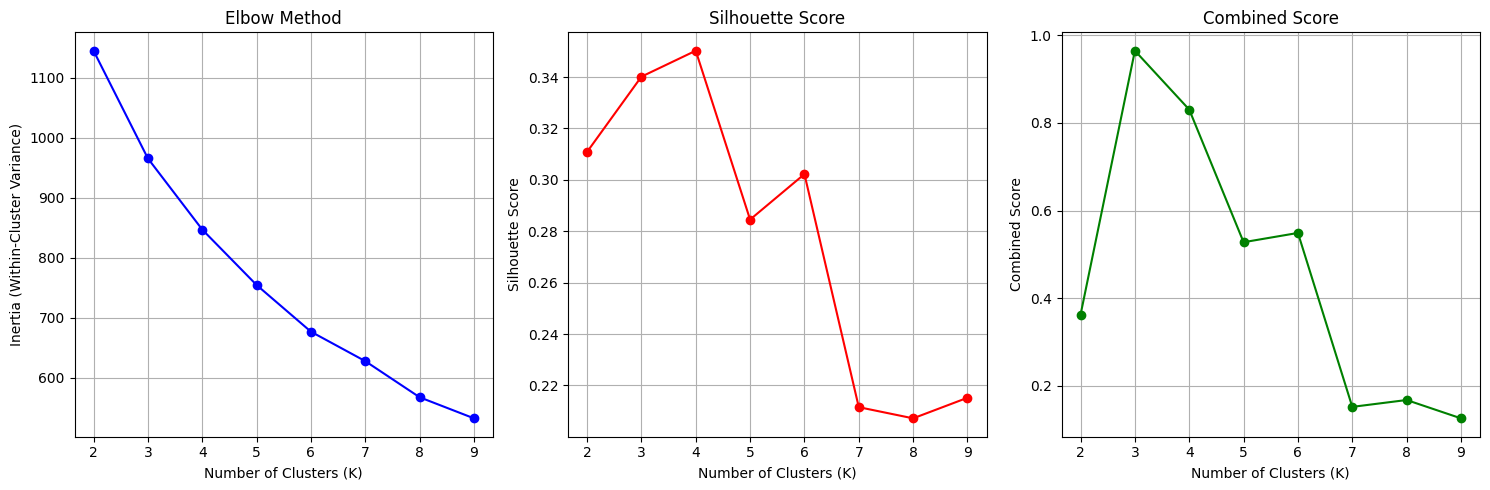


Optimal number of clusters (K): 3


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Assuming you have your data in a variable called 'data'
# If your data isn't already scaled, you should scale it first:
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(data)

# Replace 'scaled_user_features' with your actual scaled data variable name
data = scaled_user_features

# Calculate both inertia (within-cluster variance) and silhouette scores
inertias = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    # Create and fit KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data)
    
    # Calculate inertia (within-cluster variance)
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette score (measure of cluster separation)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"K={k}, Inertia={kmeans.inertia_:.2f}, Silhouette Score={silhouette_avg:.4f}")

# Calculate inertia differences (to find the "elbow")
inertia_diffs = np.diff(inertias)
inertia_diffs = np.append(0, inertia_diffs)  # Add 0 for K=2 to align with k_range

# Create a combined metric: We want high silhouette score and large inertia drop
# Normalize both metrics to 0-1 range
norm_silhouette = (silhouette_scores - min(silhouette_scores)) / (max(silhouette_scores) - min(silhouette_scores) + 1e-10)
norm_inertia_diffs = abs(inertia_diffs) / (max(abs(inertia_diffs)) + 1e-10)
combined_score = 0.5 * norm_silhouette + 0.5 * norm_inertia_diffs

# Find optimal K
optimal_k_idx = np.argmax(combined_score)
optimal_k = list(k_range)[optimal_k_idx]

# Visualize the results
plt.figure(figsize=(15, 5))

# Plot 1: Elbow Method
plt.subplot(1, 3, 1)
plt.plot(k_range, inertias, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Variance)')
plt.xticks(k_range)
plt.grid(True)

# Plot 2: Silhouette Score
plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)

# Plot 3: Combined Score
plt.subplot(1, 3, 3)
plt.plot(k_range, combined_score, 'go-')
plt.title('Combined Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Combined Score')
plt.xticks(k_range)
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nOptimal number of clusters (K): {optimal_k}")

# Create the final model with optimal K
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
final_kmeans.fit(data)

# Get the final cluster assignments
cluster_labels = final_kmeans.labels_


In [40]:
clusters = final_kmeans.predict(scaled_user_features)
clustered_users = pd.DataFrame(user_features[["user_id"]], columns=["user_id"])
clustered_users["cluster"] = clusters
clustered_users.head()

,user_id,cluster
0,U000001,0
1,U000003,0
2,U000011,0
3,U000013,2
4,U000014,2


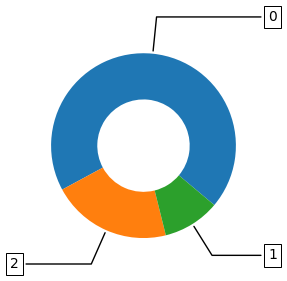

In [41]:
import matplotlib.pyplot as plt
import numpy as np

cluesters_counts = clustered_users["cluster"].value_counts().to_dict()

fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

wedges, texts = ax.pie(cluesters_counts.values(), wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(list(cluesters_counts.keys())[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

plt.show()


#### Explainability & Saving

In [42]:
centroids = final_kmeans.cluster_centers_
original_centroids = standard_scaler.inverse_transform(centroids)
original_centroids_df = pd.DataFrame(original_centroids, columns=complete_user_features.columns)

original_centroids_df.head()

,total_rides,avg_distance_km,max_distance_km,avg_pickup_latitude,avg_pickup_longitude,avg_dropoff_latitude,avg_dropoff_longitude,most_common_hour,most_common_day_of_week,weekend_ride_ratio,to_event_ratio,from_event_ratio,most_common_event,distance_variance,hour_variance,age,gender,signup_date
0,2.971014,1.342456,1.919307,40.423442,-3.692639,40.423448,-3.693131,7.942029,2.0,0.0,0.0,0.057971,0.304348,1.16295,2.972947,39.956522,0.579710,2022.913043
1,1.900000,13.257130,13.257130,40.498338,-3.567545,40.425401,-3.690378,8.200000,2.0,0.0,0.0,1.000000,1.000000,-0.40000,8.716667,36.600000,1.000000,2023.100000
2,4.000000,7.395042,10.330047,40.449420,-3.650386,40.476832,-3.603731,8.000000,2.0,0.0,0.0,0.083333,0.809524,19.54310,2.718266,43.666667,0.809524,2022.761905


Cluster 0:
- Males
- Ride the Most
- Very long Rides
- Love Events, Specially Concerts

Cluster 1:
- Somewhat Frequent Riders
- Very Short Rides
- Not very into events

Cluster 2:
- Older Clients
- Ride the least frequently
- Take the longest rides
- Somewhat into events, but middle ground between Concerts & Sports

In [43]:
from joblib import dump, load
dump(final_kmeans, 'advanced_analytics_models/user_clustering_model.joblib')
dump(standard_scaler, 'advanced_analytics_models/user_scaler.joblib')

['advanced_analytics_models/user_scaler.joblib']

### Creating Outlier Detector

#### Preparing Data

In [26]:
rides_outlier_subset = rides_with_event_info[["timestamp","pickup_latitude",
                       "pickup_longitude","dropoff_latitude","dropoff_longitude",
                       "traffic_level","distance_km","estimated_duration_minutes",
                       "actual_duration_minutes","estimated_delay_minutes",
                       "driver_speed_kmh"]]
rides_outlier_subset["month"] = rides_outlier_subset["timestamp"].dt.month
rides_outlier_subset["day"] = rides_outlier_subset["timestamp"].dt.day
rides_outlier_subset["hour"] = rides_outlier_subset["timestamp"].dt.hour
rides_outlier_subset["day_of_week"] = rides_outlier_subset["timestamp"].dt.dayofweek
rides_outlier_subset.drop(columns=["timestamp"], inplace=True)
rides_outlier_subset.head()

C:\Users\fabia\AppData\Local\Temp\ipykernel_38376\1903024466.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_outlier_subset["month"] = rides_outlier_subset["timestamp"].dt.month
C:\Users\fabia\AppData\Local\Temp\ipykernel_38376\1903024466.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_outlier_subset["day"] = rides_outlier_subset["timestamp"].dt.day
C:\Users\fabia\AppData\Local\Temp\ipykernel_38376\1903024466.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,traffic_level,distance_km,estimated_duration_minutes,actual_duration_minutes,estimated_delay_minutes,driver_speed_kmh,month,day,hour,day_of_week
0,40.408460,-3.702370,40.498333,-3.567498,HIGH,15.168999,37,70.0,26,0.000000,1,1,8,2
1,40.461591,-3.676449,40.461646,-3.676667,SEVERE,0.019388,12,NaN,31,0.000000,1,1,7,2
2,40.416757,-3.703749,40.416664,-3.703755,SEVERE,0.010333,10,NaN,46,NaN,1,1,7,2
3,40.416757,-3.703749,40.416664,-3.703755,SEVERE,0.010333,10,NaN,46,38.600246,1,1,7,2
4,40.416757,-3.703749,40.416664,-3.703755,SEVERE,0.010333,10,0.0,46,0.000000,1,1,7,2


In [27]:
# Get unique traffic levels
unique_traffic_levels = rides_outlier_subset["traffic_level"].unique()

# Create a mapping dictionary with an index for each unique traffic level
traffic_levels = {}
for i, level in enumerate(unique_traffic_levels):
    traffic_levels[level] = i

# Apply the mapping function
rides_outlier_subset["traffic_level"] = rides_outlier_subset["traffic_level"].apply(map_level, args=(traffic_levels,))

# Alternatively, you can use the map function with a default value
# rides_outlier_subset["traffic_level"] = rides_outlier_subset["traffic_level"].map(
#     traffic_levels).fillna(len(traffic_levels)).astype(int)

rides_outlier_subset.head()


C:\Users\fabia\AppData\Local\Temp\ipykernel_38376\3213754606.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_outlier_subset["traffic_level"] = rides_outlier_subset["traffic_level"].apply(map_level, args=(traffic_levels,))


,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,traffic_level,distance_km,estimated_duration_minutes,actual_duration_minutes,estimated_delay_minutes,driver_speed_kmh,month,day,hour,day_of_week
0,40.408460,-3.702370,40.498333,-3.567498,0,15.168999,37,70.0,26,0.000000,1,1,8,2
1,40.461591,-3.676449,40.461646,-3.676667,1,0.019388,12,NaN,31,0.000000,1,1,7,2
2,40.416757,-3.703749,40.416664,-3.703755,1,0.010333,10,NaN,46,NaN,1,1,7,2
3,40.416757,-3.703749,40.416664,-3.703755,1,0.010333,10,NaN,46,38.600246,1,1,7,2
4,40.416757,-3.703749,40.416664,-3.703755,1,0.010333,10,0.0,46,0.000000,1,1,7,2


In [28]:
rides_outlier_subset = rides_outlier_subset.fillna(-100)

#### Fitting & Testing

In [29]:
standard_scaler_outlier = StandardScaler()
standard_scaler_outlier = standard_scaler_outlier.fit_transform(rides_outlier_subset)
scaled_rides_outlier = pd.DataFrame(standard_scaler_outlier, columns=rides_outlier_subset.columns)
scaled_rides_outlier.head()


,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,traffic_level,distance_km,estimated_duration_minutes,actual_duration_minutes,estimated_delay_minutes,driver_speed_kmh,month,day,hour,day_of_week
0,-0.815339,-0.566009,1.982608,2.048699,-2.405351,2.108318,1.769516,1.974114,-1.554299,0.444984,0.0,-0.112509,0.156334,-0.112509
1,0.921502,-0.009817,0.823819,-0.108846,0.267261,-0.738035,-0.530797,-0.840137,-1.111163,0.444984,0.0,-0.112509,-0.354145,-0.112509
2,-0.544110,-0.595598,-0.596949,-0.644210,0.267261,-0.739737,-0.714822,-0.840137,0.218244,-1.297554,0.0,-0.112509,-0.354145,-0.112509
3,-0.544110,-0.595598,-0.596949,-0.644210,0.267261,-0.739737,-0.714822,-0.840137,0.218244,1.117608,0.0,-0.112509,-0.354145,-0.112509
4,-0.544110,-0.595598,-0.596949,-0.644210,0.267261,-0.739737,-0.714822,0.815305,0.218244,0.444984,0.0,-0.112509,-0.354145,-0.112509


In [36]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.01)
iso_forest.fit(rides_outlier_subset)
scores = iso_forest.decision_function(rides_outlier_subset)


In [38]:
scores = iso_forest.predict(rides_outlier_subset)
outliers_id = []
total_outliers = 0
for i in range(len(scores)):
    if scores[i] < 0:
        total_outliers += 1
        outliers_id.append(i)
print(f"Outliers Proportion: {total_outliers/len(scores)}")

Outliers Proportion: 0.0125


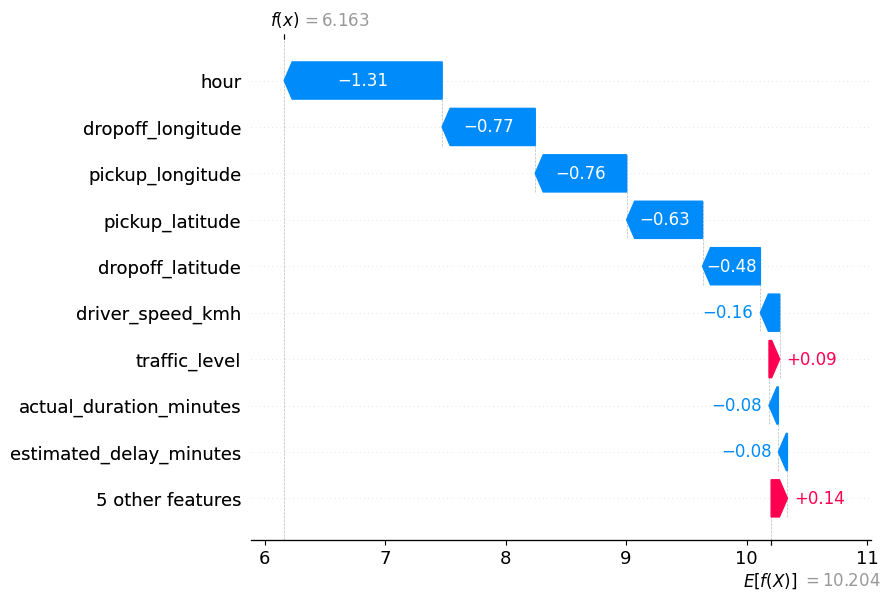

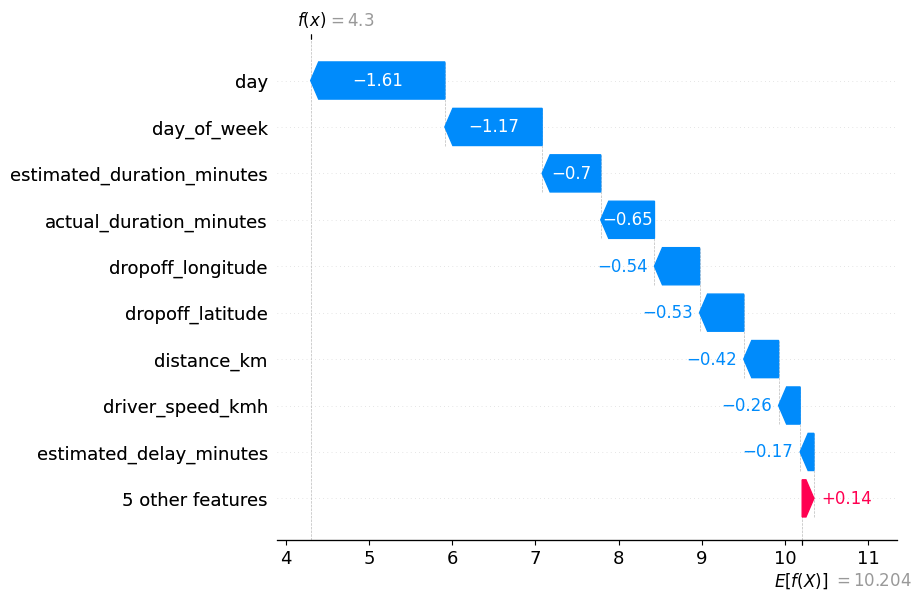

In [59]:
import shap
# Create explainer for the isolation forest model
explainer = shap.TreeExplainer(iso_forest)

# Calculate SHAP values for outliers
outlier_data = rides_outlier_subset.iloc[outliers_id]
shap_values = explainer.shap_values(outlier_data)

for i in range(len(outliers_id)):
    shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value[0],   # pass the scalar expected value
        shap_values[i],                # use the correct SHAP value for this instance
        feature_names=list(rides_outlier_subset.columns)
    )

In [61]:
dump(iso_forest, 'advanced_analytics_models/outlier_detector.joblib')
dump(standard_scaler_outlier, 'advanced_analytics_models/outlier_scaler.joblib')
dump(explainer, 'advanced_analytics_models/outlier_explainer.joblib')

# loaded_model = load('oneclass_svm_model.joblib')

# predictions = loaded_model.predict(user_features)

['advanced_analytics_models/outlier_explainer.joblib']